In [32]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma

In [48]:
# 定义先验分布
def prior_fun(batch_size=1):
    # 定义 miu 的先验: N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(loc=mean, scale=stddev)
    miu_samples = miu_dist.sample(batch_size)
    # 返回形状为 (batch_size, 1) 的先验样本
    return miu_samples[:, None]

# 定义似然函数（模拟器）
def likelihood_fun(params, n_obs=1000):
    miu = params[:, 0]  # 提取 miu
    sigma = 1  # 固定 sigma = 1
    return tf.random.normal(
        shape=(params.shape[0], n_obs, 1),
        mean=miu[:, None],
        stddev=sigma
    )

In [49]:
# 定义生成模型
prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# 定义总结网络
summary_net = bf.networks.DeepSet(summary_dim=10)

# 定义推断网络
inference_net = bf.networks.InvertibleNetwork(
    num_params=1,  # 只预测 miu
    num_coupling_layers=4,
)

# 定义后验推断器
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# 定义 Trainer
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

# 执行一次模型调用（可选，用于验证模型是否工作正常）
_ = model(batch_size=32)

# 开始在线训练
history = trainer.train_online(
    epochs=1,               # 训练 10 个 epoch
    iterations_per_epoch=500,  # 每个 epoch 的迭代次数
    batch_size=32,            # 每次训练的批量大小
    validation_sims=200       # 验证集样本数
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [00:51<00:00,  9.78it/s, Epoch: 1, Iter: 500,Loss: -1.182,W.Decay: 0.144,Avg.Loss: -0.093,Avg.W.Decay: 0.152,LR: 4.93E-09]
INFO:root:Validation, Epoch: 1, Loss: -1.719


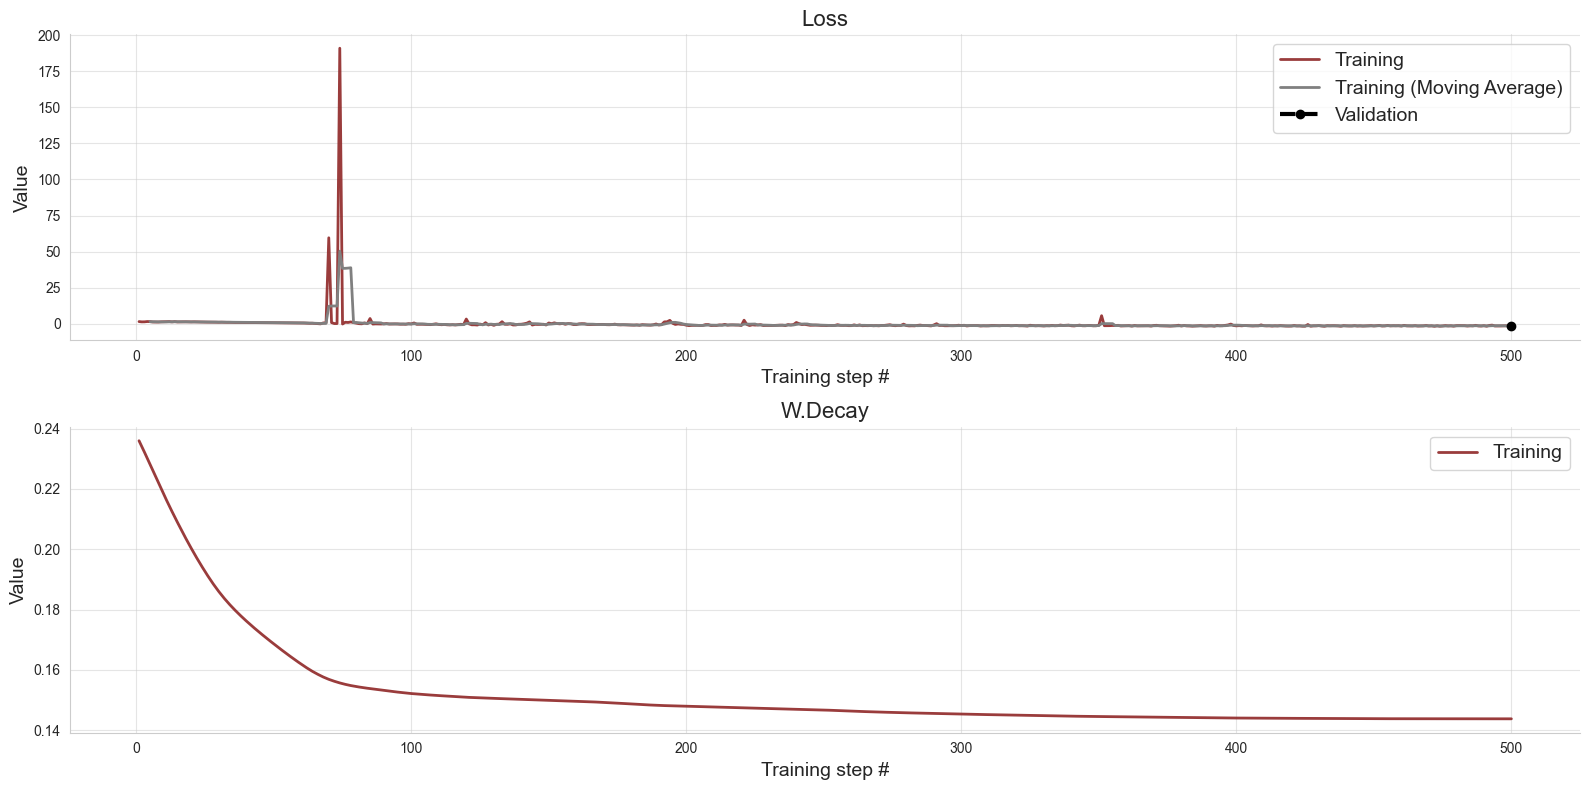

In [54]:
# 可视化训练和验证损失
f = bf.diagnostics.plot_losses(
    history["train_losses"], 
    history["val_losses"], 
    moving_average=True
)

Summary vector shape:  (1, 1000, 10)
Posterior samples shape:  (1000, 1)


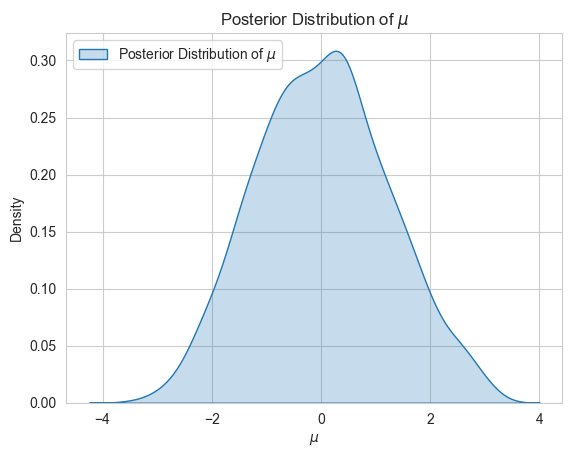

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 生成真实数据
n_obs = 1000  # 样本数量
true_miu = 0  # 真实均值
true_sigma = 1  # 固定标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

# 2. 使用总结网络提取观测数据特征
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # 应输出形状 (1, summary_dim)

# 3. 推断后验分布
# 使用推断网络对观测数据进行推断
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)
print("Posterior samples shape: ", posterior_samples.shape)  # 应输出形状 (1000, 1)

# 提取 miu 的后验样本
miu_samples = posterior_samples[:, 0]

# 4. 可视化后验分布
# 绘制 mu 的后验分布直方图
sns.kdeplot(miu_samples, label="Posterior Distribution of $\mu$", fill=True)
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.title("Posterior Distribution of $\mu$")
plt.legend()
plt.show()



In [56]:
# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = Z.size  # 样本数量

# 后验均值 μ'
mu_post = (mu_0 + n * Y_mean) / (1 + n)

# 后验方差 σ_post^2
sigma_post_sq = sigma_0_sq / (1 + n)

# 输出结果
print("Posterior Mean (mu_post):", mu_post)
print("Posterior Variance (sigma_post_sq):", sigma_post_sq)


Posterior Mean (mu_post): -0.010852130701194158
Posterior Variance (sigma_post_sq): 0.000999000999000999


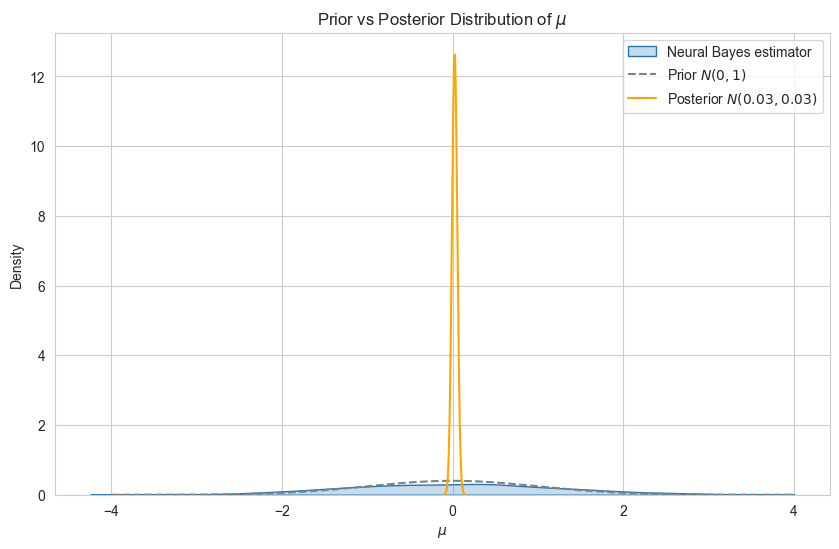

In [57]:
import matplotlib.pyplot as plt

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 5. 计算并可视化 Prior 与 Posterior 分布
mu_prior = 0  # Prior 的均值
sigma_prior = 1  # Prior 的标准差

# 定义 Prior 分布
normal_prior = torch.distributions.Normal(loc=torch.tensor(mu_prior), scale=torch.tensor(sigma_prior))
x_prior = torch.linspace(mu_prior - 4 * sigma_prior, mu_prior + 4 * sigma_prior, 500)
pdf_prior = torch.exp(normal_prior.log_prob(x_prior))

# 计算 Posterior 分布
mu_poster = np.mean(miu_samples)
sigma_poster = np.sqrt(sigma_post_sq)
normal_poster = torch.distributions.Normal(loc=torch.tensor(mu_poster), scale=torch.tensor(sigma_poster))
x_poster = torch.linspace(mu_poster - 4 * sigma_poster, mu_poster + 4 * sigma_poster, 500)
pdf_poster = torch.exp(normal_poster.log_prob(x_poster))

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
ax.plot(x_prior.numpy(), pdf_prior.numpy(), label=f"Prior $N({mu_prior}, {sigma_prior})$", linestyle="--", color="grey")
ax.plot(x_poster.numpy(), pdf_poster.numpy(), label=f"Posterior $N({mu_poster:.2f}, {sigma_poster:.2f})$", color="orange")
ax.set_xlabel("$\mu$")
ax.set_ylabel("Density")
ax.set_title("Prior vs Posterior Distribution of $\mu$")
ax.legend()
plt.show()